# Pytorch: modules

In the previous notebook, we have laboriously trained a neural network written by hand. Pytorch actually contains many modules that make the definition of a network, the data collection and the training very easy.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Neural network module

The `torch.nn` module allows to easily define complicated networks. It implements basic linear and convolutional layers, and allows to build with them easily. To do so, we define a `nn.Module` class.

This class has two methods:

* `__init__` specifies the different layers of the network
* `forward` defines how to go from the input to the output using the layers defined in the init.

For instance, this is how you would define a simple neural network with one hidden layer of size $100$, that takes $10$ inputs and returns $3$ outputs:

In [2]:
class Two_layers(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(10, 100)
        self.layer2 = nn.Linear(100, 3)

    def forward(self, x):
        y = self.layer1(x)
        y = torch.tanh(y)
        y = self.layer2(y)
        return y 
    
net = Two_layers()

In [3]:
x = torch.randn(1000, 10)
net(x)

tensor([[-0.1053, -0.1911, -0.1313],
        [ 0.1073, -0.2761, -0.0967],
        [ 0.1579,  0.0935, -0.2482],
        ...,
        [ 0.2827,  0.0986, -0.2683],
        [ 0.2398, -0.1581, -0.3249],
        [-0.3490, -0.4674,  0.1883]], grad_fn=<AddmmBackward>)

# Optim module

The `torch.optim` module then allows to easily learn the parameters of the net with backprop. An optimizer, like SGD, takes the parameters of the network as input.

In [4]:
import torch.optim as optim

optimizer = optim.SGD(lr=1e-2, params=net.parameters())

We can then compute a (toy) loss, backpropagate, and use the `optimizer.step` method to make an update:

In [5]:
optimizer.zero_grad()
y = net(x)
loss = y.sum()
loss.backward()
optimizer.step()

And that is it ! 

# Datasets
There are also some convenient tools to load datasets. For instance, we will work with MNIST:

In [6]:
from torchvision import datasets, transforms

Let's download the MNIST dataset, the train and testing data, and apply a simple normalizing transform.

In [7]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                   transform=transform)

We can then define a loader that will automatically load the images when we train / test

In [8]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

We can then loop over these loaders to get the images:

torch.Size([128, 1, 28, 28])
torch.Size([128])


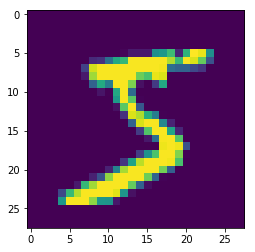

In [9]:
for x, y in train_loader:
    print(x.shape)
    print(y.shape)
    plt.imshow(x[0, 0])
    break

We are now ready to train a network on MNIST ! 

# Training on MNIST

**Exercise 1**: Define a one hidden neural network for MNIST, with a hidden layer of size $1000$.

In [10]:
class Two_layers(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(784, 1000)
        self.layer2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.layer1(x)
        x = torch.tanh(x)
        x = self.layer2(x)
        return x
    
net = Two_layers()

In [11]:
for x, y in train_loader:
    print(net(x))
    break

tensor([[ 0.1435,  0.4236,  0.1076,  ...,  0.0161, -0.3263, -0.0886],
        [ 0.2493, -0.1208,  0.2512,  ...,  0.1650, -0.6417, -0.3964],
        [ 0.0565,  0.1519,  0.4932,  ...,  0.2916, -0.2066,  0.2903],
        ...,
        [ 0.1148,  0.5851,  0.1935,  ...,  0.0707, -0.0901,  0.0350],
        [ 0.0018, -0.0179,  0.0965,  ..., -0.6119, -0.1885,  0.2485],
        [ 0.0730, -0.4021,  0.1965,  ..., -0.1827,  0.0123,  0.1386]],
       grad_fn=<AddmmBackward>)


**Exercise 2** : Define an SGD optimizer for this network

In [12]:
optimizer = optim.SGD(params=net.parameters(), lr=0.1)

**Exercise 3**: Perform one training epoch on the data, and compute the testing accuracy. Use the cross entropy as loss.

In [13]:
from torch.nn.functional import cross_entropy

In [14]:
for i, (x, y) in enumerate(train_loader):
    optimizer.zero_grad()
    pred = net(x)
    loss = cross_entropy(pred, y)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(i, loss.item())

0 2.344902276992798
100 0.2804979383945465
200 0.21513313055038452
300 0.2657667100429535
400 0.35627543926239014


In [15]:
good_preds = 0
for x, y in test_loader:
    pred = net(x)
    good_preds += (pred.argmax(axis=1) == y).sum().item()

print(good_preds / 10000)

0.9195


You should get ~ 90% accuracy.

**Exercise 4**: Now, train a convolutionnal network, and try to get the best accuracy.

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.pool = nn.MaxPool2d(2)
        self.layer1 = nn.Linear(1600, 100)
        self.layer2 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        x = self.layer1(x)
        x = torch.tanh(x)
        x = self.layer2(x)
        return x
    
net = CNN()

for x, y in train_loader:
    print(net(x))
    break

tensor([[ 0.3660,  0.0246, -0.0590,  ..., -0.1527, -0.3858, -0.0658],
        [ 0.1150, -0.0770, -0.0401,  ...,  0.0449, -0.2715, -0.0288],
        [ 0.2353, -0.2011,  0.0502,  ...,  0.3168, -0.0948,  0.0249],
        ...,
        [ 0.3608,  0.0155, -0.0553,  ..., -0.0915, -0.3667,  0.0227],
        [ 0.1718,  0.0236, -0.0153,  ..., -0.1059, -0.2888, -0.1986],
        [ 0.2646,  0.0075,  0.0214,  ...,  0.1012, -0.2328,  0.1627]],
       grad_fn=<AddmmBackward>)


In [17]:
optimizer = optim.SGD(params=net.parameters(), lr=0.1)

In [18]:
for i, (x, y) in enumerate(train_loader):
    optimizer.zero_grad()
    pred = net(x)
    loss = cross_entropy(pred, y)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(i, loss.item())

0 2.2947137355804443
100 0.1571812927722931
200 0.10624870657920837
300 0.09976629912853241
400 0.14219069480895996


In [19]:
good_preds = 0
for x, y in test_loader:
    pred = net(x)
    good_preds += (pred.argmax(axis=1) == y).sum().item()

print(good_preds / 10000)

0.9786


**Exercise 5**: Put this model on a GPU, and compare the training time.
To put a model to GPU, you can to `net.to('cuda')`. The data `x` and `y`should also be put on the GPU.